<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/master/notebooks/4a_validacion_cruzada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selección de modelos de regresión
En esta libreta evaluaremos un modelo de regresión usando valación cruzada.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston

Definimos la función de pérdida de error cuadrático medio
$$
ECM(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{n} \sum_{i=1}^{n}  (\hat{y}^{(i)} - y^{(i)})^2
$$ 

In [2]:
def ecm(y, y_hat):
  return np.square(y_hat - y).mean()

Definimos la función para realizar validación cruzada aleatoria

In [3]:
def vc_aleatorio(X, y, r = 100, t_ent=0.8):
  n = X.shape[0]
  for i in range(r):
    perm = np.random.permutation(n)
    
    X = X[perm,:]
    y = y[perm]
    
    X_ent = X[:int(X.shape[0] * t_ent),:]
    y_ent = y[:int(X.shape[0] * t_ent)]

    X_val = X[int(X.shape[0] * t_ent):,:]
    y_val = y[int(X.shape[0] * t_ent):]
    
    yield i, X_ent, y_ent, X_val, y_val

De forma similar, definimos la función para realizar validación cruzada de $K$ particiones

In [4]:
def vc_kpart(X, y, k = 5):
  n = X.shape[0]
  t_pliegue = int(n / k)
  for i in range(k):
    masc_val = np.zeros(n, dtype=bool)
    masc_val[t_pliegue * i:t_pliegue * (i + 1)] = True
    ent_mask = np.logical_not(masc_val)
    X_ent = X[ent_mask, :]
    y_ent = y[ent_mask]
    X_val = X[masc_val, :]
    y_val = y[masc_val]
    
    yield i, X_ent, y_ent, X_val, y_val

Validación de K particiones con repetición

In [5]:
def vcrep_kpart(X, y, r=10, k=4):
  n = X.shape[0]
  for i in range(r):
    perm = np.random.permutation(n)
    X = X[perm,:]
    y = y[perm]
    t_pliegue = int(n / k)
    for j in range(k):
      masc_val = np.zeros(n, dtype=bool)
      masc_val[t_pliegue*j:t_pliegue*(j+1)] = True
      ent_mask = np.logical_not(masc_val)
      X_ent = X[ent_mask, :]
      y_ent = y[ent_mask]
      X_val = X[masc_val, :]
      y_val = y[masc_val]
      
      yield i, j, i * k + j, X_ent, y_ent, X_val, y_val

Definimos la función para escalar los atributos

In [6]:
class EscaladoEstandar:
  def fit(self, X):
    self.media = X.mean(axis=0).reshape(1,-1)
    self.std = X.std(axis=0).reshape(1,-1)
    
  def transform(self, X):
    return (X - self.media) / self.std

  def fit_transform(self, X):
    self.fit(X)
    return self.transform(X)

Nuestra función de expansión polinomial

In [7]:
def expol(X, grado):
  phi_X = X
  for i in range(grado - 1):
    powerX = np.power(X, i + 2)
    phi_X = np.column_stack((phi_X, powerX))
    
  unos = np.ones(phi_X.shape[0])
  return np.column_stack((unos, phi_X))

Definimos nuestra función para entrenar y validar el modelo de regresión con expansión polinomial de un grado dado

In [8]:
def entrena_evalua(m, X_ent, y_ent, X_val, y_va, g):
  es = EscaladoEstandar()
  X_ent = expol(es.fit_transform(X_ent), g)
  X_val = expol(es.transform(X_val), g)

  m.fit(X_ent, y_ent)

  y_hat_ent = m.predict(X_ent)
  y_hat_val = m.predict(X_val)

  ecm_ent = ecm(y_ent, y_hat_ent)
  ecm_val = ecm(y_val, y_hat_val) 

  return ecm_ent, ecm_val

Creamos nuestra clase base para regresión lineal

In [9]:
class RegresionLineal():
  def fit(self, X, y):
    '''
    Estima los parámetros del modelo
    '''
    self._estima_parametros(X, y)
  
  def predict(self, X):
    '''
    Predice valores de vectores dados
    '''
    return X @ self.parametros

Generamos un hijo de esta clase para mínimos cuadrados usando descomposición QR

In [10]:
class MinimosCuadradosQR(RegresionLineal):
  def _estima_parametros(self, X, y):
    q, r = np.linalg.qr(X)
    self.parametros = np.linalg.inv(r) @ q.T @ y

La evaluación la vamos a realizar con el conjunto de datos de precios de casas de la ciudad de Boston, la cual se puede descargar desde scikit-learn

In [11]:
boston = load_boston()

Entrenamos y validamos nuestro modelo

In [12]:
grados = np.arange(1,7,1)
ecm_ent_grados = np.zeros((grados.shape[0], 40))
ecm_val_grados = np.zeros((grados.shape[0], 40))
X = boston.data
y = boston.target
for i,g in enumerate(grados):
  for j,k,l, X_ent, y_ent, X_val, y_val in vcrep_kpart(X, y, r=10, k=4):
    rl = MinimosCuadradosQR()
    ecm_ent_grados[i,l], ecm_val_grados[i,l] = entrena_evalua(rl, X_ent, y_ent,
                                                              X_val, y_val, g)

Graficamos los errores cuadráticos medios de entrenamiento y validación

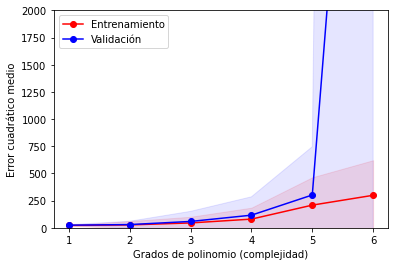

In [13]:
ent_media_rl = np.mean(ecm_ent_grados, axis=1)
ent_std_rl = np.std(ecm_ent_grados, axis=1)

val_media_rl = np.mean(ecm_val_grados, axis=1)
val_std_rl = np.std(ecm_val_grados, axis=1)
    
plt.fill_between(grados, ent_media_rl - ent_std_rl,
                  ent_media_rl + ent_std_rl, alpha=0.1,
                  color="r")
plt.fill_between(grados, val_media_rl - val_std_rl,
                  val_media_rl + val_std_rl, alpha=0.1,
                  color="b")

plt.plot(grados, ecm_ent_grados.mean(axis=1), 'o-', color="r",
         label="Entrenamiento")
plt.plot(grados, ecm_val_grados.mean(axis=1), 'o-', color="b",
         label=u"Validación")
plt.xticks(grados)
plt.xlabel('Grados de polinomio (complejidad)')
plt.ylabel('Error cuadrático medio')
plt.ylim([0, 2000])
plt.legend()
plt.show()

Para mínimos cuadrados penalizados por norma $\ell_2$ tenemos

In [14]:
class MinimosCuadradosL2QR(RegresionLineal):
  def __init__(self, lc = 0.01):
    self._lc = lc

  def _estima_parametros(self, X, y):
    lcI = np.sqrt(self._lc * np.identity(X.shape[1]))
    X_tilde = np.concatenate((X, lcI))
    y_tilde = np.concatenate((y, np.zeros(X.shape[1])))
    q, r = np.linalg.qr(X_tilde)
    self.parametros = np.linalg.inv(r) @ q.T @ y_tilde

Evaluamos el rendimiento para distintos valores de $\lambda$.

In [15]:
lambdas = np.geomspace(1e-20, 1e20, num=9)
ecm_ent_lambdas = np.zeros((lambdas.shape[0],40))
ecm_val_lambdas = np.zeros((lambdas.shape[0],40))
for i,l in enumerate(lambdas):
  for _, _, j, X_ent, y_ent, X_val, y_val in vcrep_kpart(X, y, r=10, k=4):
    rlreg = MinimosCuadradosL2QR(lc=l)
    ecm_ent_lambdas[i,j], ecm_val_lambdas[i,j] = entrena_evalua(rlreg, 
                                                                X_ent, y_ent,
                                                                X_val, y_val, 6)

Graficamos los errores para entrenamiento y validación

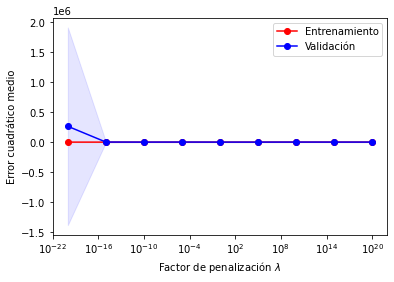

In [16]:
ent_media_rlreg = np.mean(ecm_ent_lambdas, axis=1)
ent_std_rlreg = np.std(ecm_ent_lambdas, axis=1)

val_media_rlreg = np.mean(ecm_val_lambdas, axis=1)
val_std_rlreg = np.std(ecm_val_lambdas, axis=1)
    
plt.fill_between(lambdas, ent_media_rlreg - ent_std_rlreg,
                  ent_media_rlreg + ent_std_rlreg, alpha=0.1,
                  color="r")
plt.fill_between(lambdas, val_media_rlreg - val_std_rlreg,
                  val_media_rlreg + val_std_rlreg, alpha=0.1,
                  color="b")

plt.plot(lambdas, ent_media_rlreg, 'o-', color="r",
         label="Entrenamiento")
plt.plot(lambdas, val_media_rlreg, 'o-', color="b",
         label=u"Validación")
plt.xscale('log')
plt.xlabel('Factor de penalización $\lambda$')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.show()